In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feedforward_nn import NeuralNetwork
from gradient_descent import GradientDescent
from regression_tools import accuracy
from regression_cost_funcs import LogisticCost

from sklearn.datasets import load_breast_cancer as wbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [26]:
"""
# Load data
data = wbc()
X = data.data
y = data.target

# Split data into training and test sets
X_TR, X_test, z_TR, z_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, z_train, z_val = train_test_split(X_TR, z_TR, test_size=0.2)
n = X_train.shape[1]

np.save("data/wbc/X_TR.npy", X_TR)
np.save("data/wbc/X_train.npy", X_train)
np.save("data/wbc/X_val.npy", X_val)
np.save("data/wbc/X_test.npy", X_test)
np.save("data/wbc/z_TR.npy", z_TR)
np.save("data/wbc/z_train.npy", z_train)
np.save("data/wbc/z_val.npy", z_val)
np.save("data/wbc/z_test.npy", z_test)
"""

X_TR = np.load("data/wbc/X_TR.npy")
X_train = np.load("data/wbc/X_train.npy")
X_val = np.load("data/wbc/X_val.npy")
X_test = np.load("data/wbc/X_test.npy")
z_TR = np.load("data/wbc/z_TR.npy")
z_train = np.load("data/wbc/z_train.npy")
z_val = np.load("data/wbc/z_val.npy")
z_test = np.load("data/wbc/z_test.npy")
n = X_train.shape[1]

# Use hstack to add a column of ones to the data
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
X_TR = np.hstack((np.ones((X_TR.shape[0], 1)), X_TR))



In [27]:
# Use minimax to scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_TR = scaler.transform(X_TR)


First we analyze how each mode converges.

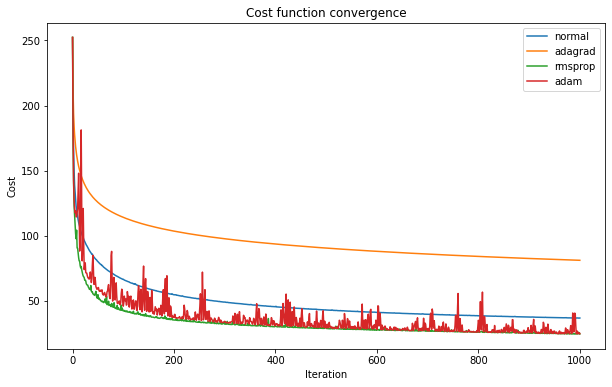

In [40]:
# Convergence analysis
# Set up the cost function
modes = ["normal", "adagrad", "rmsprop", "adam"]
cost_arr = []
for mode in modes:
    modelcost = LogisticCost(regularization=0)

    w0 = np.zeros((n + 1, 1))
    gd = GradientDescent(batch_size=16, mode=mode, momentum_param=0.9, store_extra=True)
    gd.train(X_train, w0, z_train, modelcost, learning_rate=0.005, n_epochs=1000)
    cost_arr.append(gd.costs)

# Plot the cost function
plt.figure(figsize=(10, 6))
for i, mode in enumerate(modes):
    plt.plot(cost_arr[i], label=mode)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost function convergence")
plt.legend()
plt.show()


We transfer most of the parameters from the analysis on the neural network; that is, we have momentum=0.9, batch_size=16, and learning_rate=0.0005. We perform an analysis on the four different modes, using a grid-search on the regularization parameter.

In [30]:
def optimal_reg_logistic_regression(X_train, 
                                    z_train, 
                                    X_val, 
                                    z_val, 
                                    regularizationrange, 
                                    momentum=0.9,
                                    optmode="normal", 
                                    max_iter=200, 
                                    eta=0.01,
                                    ):
    """Returns the optimal regularization parameter for a logistic regression with the given parameters, taking the average over avg_num runs."""
    accuracy_val = []
    cost_val = []
    for reg in regularizationrange:
        logcost = LogisticCost(regularization=reg)
        w0 = np.zeros(n+1)
        batch_size = 16
        store_extra = True

        gd = GradientDescent(batch_size=batch_size, momentum_param=momentum, store_extra=store_extra, mode=optmode)
        w = gd.train(X_train, w0, z_train, logcost, eta, max_iter)
        cost = gd.costs[-1]
        z_pred = logcost.predict_class(X_val, w)
        acc = accuracy(z_val, z_pred)
        accuracy_val.append(acc)
        cost_val.append(cost)
    # Return best regularization parameter, corresponding accuracy and accuracy_val
    return regularizationrange[np.argmax(accuracy_val)], np.max(accuracy_val), accuracy_val, cost_val

In [70]:
# Grid search on regularization parameter and learning rate for each mode - low resolution, as we only want to find the best mode
modes = ["normal", "adagrad", "rmsprop", "adam"]
best_lam = [[], [], [], []]
best_acc = [[], [], [], []]
accuracy_val = [[], [], [], []]
cost_val = [[], [], [], []]
max_iter = 1000
eta = 0.005
lambdas = np.logspace(-5, 0, 10)
lr = np.logspace(-5, 0, 10)
for i, mode in enumerate(modes):
    for l in lr:
        print("Mode: {}, learning rate: {}".format(mode, l), end="\r")
        best_l, best_a, acc, cost = optimal_reg_logistic_regression(X_train, z_train, X_val, z_val, lambdas, optmode=mode, max_iter=max_iter, eta=l)
        best_lam[i].append(best_l)
        best_acc[i].append(best_a)
        accuracy_val[i].append(acc)
        cost_val[i].append(cost)
        

c:\Users\leand\FYS-STK\FYS-STK3155-project-2\regression_cost_funcs.py:181: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-X @ w)) > 0.5).astype(int)


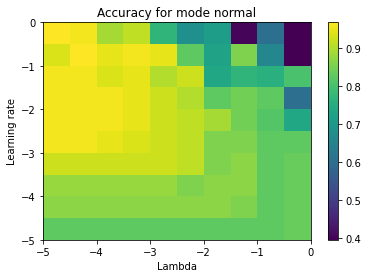

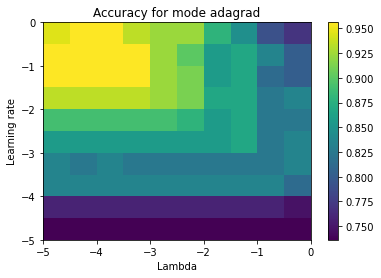

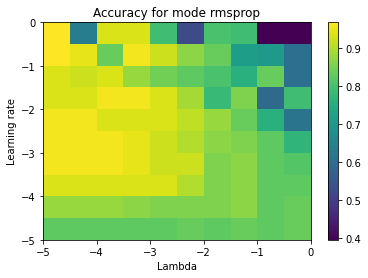

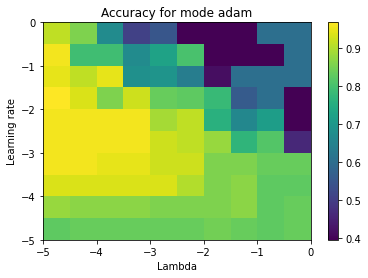

Mode, Best lambda, Best accuracy, Best learning rate
normal, 0.000036, 0.9670, 0.278256
adagrad, 0.000010, 0.9560, 0.077426
rmsprop, 0.000010, 0.9670, 0.278256
adam, 0.000010, 0.9670, 0.021544


In [85]:
# Make heatmap plot of accuracy vs. learning rate and regularization parameter
for i in range(len(modes)):
    accuracy_mat = np.array(accuracy_val[i])
    X, Y = np.meshgrid(lambdas, lr)
    fig = plt.figure()
    plt.imshow(accuracy_mat, extent=[np.log10(lambdas[0]), np.log10(lambdas[-1]), np.log10(lr[0]), np.log10(lr[-1])], origin="lower", aspect="auto")
    plt.colorbar()
    plt.xlabel("Lambda")
    plt.ylabel("Learning rate")
    plt.title(f"Accuracy for mode {modes[i]}")
    # Save figure to folder Results
    plt.savefig(f"Results/accuracy_{modes[i]}_logistic_heatmap.png")
    plt.show()

# Find best regularization parameter-learning rate combination for each mode and print as table
best_lamda = []
best_accur = []
best_learning_rate = []
for i in range(len(modes)):
    for j in range(len(lr)):
        if best_acc[i][j] == np.max(best_acc[i]):
            best_lamda.append(best_lam[i][j])
            best_accur.append(best_acc[i][j])
            best_learning_rate.append(lr[j])
            break

# Print table
print(f"Mode, Best lambda, Best accuracy, Best learning rate")
for i in range(len(modes)):
    print(f"{modes[i]}, {best_lamda[i]:.6f}, {best_accur[i]:.4f}, {best_learning_rate[i]:6f}")
    





In [86]:
# Use best mode and regularization parameter to train model on full training set
best_mode = modes[np.argmax(best_accur)]
best_lam = best_lamda[np.argmax(best_accur)]
best_eta = best_learning_rate[np.argmax(best_accur)]
print(f"Best mode: {best_mode}, best lambda: {best_lam}, best learning rate: {best_eta}")

# Train model on full training set
logcost = LogisticCost(regularization=best_lam)
w0 = np.zeros(n+1)
batch_size = 16
store_extra = True

gd = GradientDescent(batch_size=batch_size, momentum_param=0.9, store_extra=store_extra, mode=best_mode)
w = gd.train(X_TR, w0, z_TR, logcost, best_eta, 1000)
cost = gd.costs[-1]
z_pred = logcost.predict_class(X_test, w)
acc = accuracy(z_test, z_pred)
print(f"Accuracy on test set: {acc}")



Best mode: normal, best lambda: 3.5938136638046256e-05, best learning rate: 0.2782559402207126
Accuracy on test set: 0.9298245614035088
